SE = 16.50 bit/s/Hz


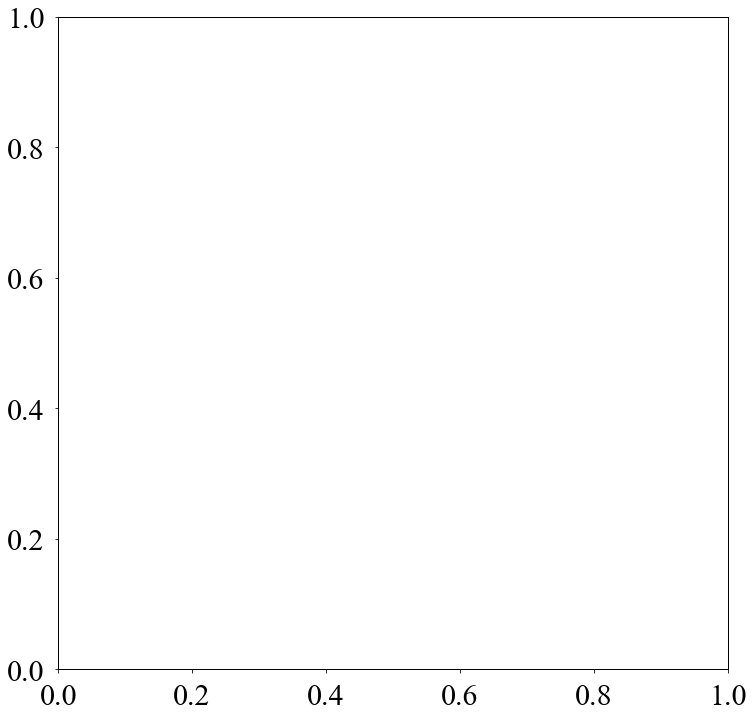

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

mpl.rcParams['axes.linewidth'] = 1
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = (12,12)
plt.rcParams["font.family"] = "Times New Roman"
plt.tick_params(axis='both', which='major', pad=10)
marker_style = dict(linestyle='-', markersize=15, markeredgewidth=2.5, linewidth=3, fillstyle='none', clip_on=False)

AdaptSky_x = []
AdaptSky_y = []
UAV_CONSTANT_POWER = 10


class DQN(nn.Module):
    def __init__(self, NUMBER_OF_ARGUMENTS_PER_STATE):
        super().__init__(),

        self.fc1 = nn.Linear(in_features=NUMBER_OF_ARGUMENTS_PER_STATE, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=128) 
        self.out_v = nn.Linear(in_features=128, out_features=1)
        self.out_a = nn.Linear(in_features=128, out_features=32)

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        v = self.out_v(t) #Value Stream
        a = self.out_a(t) # Advantage Stream
        q = v + a - a.mean()
        return q
    
def mmLineOfSight_Check(D,H):
    return 1
    C = 9.6117 # Urban LOS probability parameter 
    Y = 0.1581 # Urban LOS probability parameter
    RAND = random.uniform(0,1)
    teta = math.asin(H/D) * 180/math.pi
    p1 = 1 / ( 1 + (C * math.exp( -Y * (teta - C ) ) ) )
    p2 = 1 - p1
    if p1 >= p2:
        if RAND >= p2:
            L = 1
        else:
            L = 2
    else:
        if RAND >= p1:
            L = 2
        else:
            L = 1
    return L

def Average(lst): 
    return sum(lst) / len(lst) 

class Blob():
    def __init__(self, size, USER1=False, USER2=False, USER3=False, USER4=False):
        self.size = size
        if USER1:
            self.x = 35
            self.y = 54
        elif USER2:
            self.x = 94
            self.y = 1
        elif USER3:
            self.x = 29
            self.y = 45
        elif USER4:
            self.x = 1
            self.y = 97
        else:
            self.x = 50
            self.y = 50

    def __str__(self):
        return f"Blob({self.x}, {self.y})"

    def __sub__(self, other):
        return [(self.x-other.x)/10, (self.y-other.y)/10]

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        
        if choice == 0:
            self.move(x=1, y=1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H += 1

        elif choice == 1:
            self.move(x=-1, y=-1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H += 1

        elif choice == 2:
            self.move(x=-1, y=1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H += 1

        elif choice == 3:
            self.move(x=1, y=-1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H += 1
            
        elif choice == 4:
            self.move(x=1, y=1)
            self.a1 += 0.01
            self.a3 -=0.01
            self.H += 1

        elif choice == 5:
            self.move(x=-1, y=-1)
            self.a1 += 0.01
            self.a3 -= 0.01
            self.H += 1

        elif choice == 6:
            self.move(x=-1, y=1)
            self.a1 += 0.01
            self.a3 -= 0.01
            self.H += 1

        elif choice == 7:
            self.move(x=1, y=-1)
            self.a1 += 0.01
            self.a3 -= 0.01
            self.H += 1
            
        elif choice == 8:
            self.move(x=1, y=1)
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H += 1
            
        elif choice == 9:
            self.move(x=-1, y=-1)
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H += 1

        elif choice == 10:
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H += 1

        elif choice == 11:
            self.move(x=1, y=-1)
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H += 1
            
        elif choice == 12:
            self.move(x=1, y=1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H += 1

        elif choice == 13:
            self.move(x=-1, y=-1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H += 1

        elif choice == 14:
            self.move(x=-1, y=1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H += 1

        elif choice == 15:
            self.move(x=1, y=-1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H += 1
            
        if choice == 16:
            self.move(x=1, y=1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H -= 1

        elif choice == 17:
            self.move(x=-1, y=-1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H -= 1

        elif choice == 18:
            self.move(x=-1, y=1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H -= 1

        elif choice == 19:
            self.move(x=1, y=-1)
            self.a1 += 0.01
            self.a3 +=0.01
            self.H -= 1
            
        elif choice == 20:
            self.move(x=1, y=1)
            self.a1 += 0.01
            self.a3 -=0.01
            self.H -= 1

        elif choice == 21:
            self.move(x=-1, y=-1)
            self.a1 += 0.01
            self.a3 -= 0.01
            self.H -= 1

        elif choice == 22:
            self.move(x=-1, y=1)
            self.a1 += 0.01
            self.a3 -= 0.01
            self.H -= 1

        elif choice == 23:
            self.move(x=1, y=-1)
            self.a1 += 0.01
            self.a3 -= 0.01
            self.H -= 1
            
        elif choice == 24:
            self.move(x=1, y=1)
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H -= 1
            
        elif choice == 25:
            self.move(x=-1, y=-1)
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H -= 1

        elif choice == 26:
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H -= 1

        elif choice == 27:
            self.move(x=1, y=-1)
            self.a1 -= 0.01
            self.a3 += 0.01
            self.H -= 1
            
        elif choice == 28:
            self.move(x=1, y=1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H -= 1

        elif choice == 29:
            self.move(x=-1, y=-1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H -= 1

        elif choice == 30:
            self.move(x=-1, y=1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H -= 1

        elif choice == 31:
            self.move(x=1, y=-1)
            self.a1 -= 0.01
            self.a3 -= 0.01
            self.H -= 1
            
        if self.a1 > 1:
            self.a1 = 1
        elif self.a1 < 0:
            self.a1 = 0
        if self.a3 > 1:
            self.a3 = 1
        elif self.a3 < 0:
            self.a3 = 0
        if self.H <= 10:
            self.H =10
        

    def move(self, x=False, y=False):

        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        if self.x < 0:
            self.x = 0
        elif self.x > self.size-1:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        elif self.y > self.size-1:
            self.y = self.size-1

class BlobEnv():
    SIZE = 100
    MOVE_PENALTY = 1
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    UAV_N = 1  # UAV key in dict
    USER_N = 2  # USER key in dict
    UAV2_N = 4  # UAV2 key in dict
    # the dict! (colors)
    d = {1: (255, 175, 0),
         2: (0, 255, 0),
         3: (0, 0, 255),
         4: (175, 0, 255)}

    def reset(self):
        P_T = 10**((p-30)/10) # Transmitted power 20dbm (i.e. .1w)
        N_uav = 8
        N_ue = 8
        G = N_uav * N_ue
        P = P_T*G
        W = 2e9 # Bandwidth 2GHz
        fc = 28e9 # Carrier frequency = 28GHz
        NF = 10**(5/10) # 5dB Noise Figure 
        TN = 10**(-114/10) # -84dBm Thermal Noise
        N = NF * TN
        C_LOS = 10**(-6.4)
        a_LOS = 2
        C_NLOS = 10**(-7.2) 
        a_NLOS = 2.92

        self.UAV = Blob(self.SIZE)
        
        self.SUM1 = []
        self.SUM2 = []
        self.SUM3 = []
        self.SUM4 = []
        
        self.UAV.a1 = 0.5
        self.UAV.a2 = 0.5
        self.UAV.a3 = 0.5
        self.UAV.a4 = 0.5
        self.UAV.H = 50
        
        self.USER1 = Blob(self.SIZE, True, False, False, False)
        self.USER2 = Blob(self.SIZE, False, True, False, False)
        self.USER3 = Blob(self.SIZE, False, False, True, False)
        self.USER4 = Blob(self.SIZE, False, False, False, True)
        
        
        ob1 = self.UAV-self.USER1
        ob2 = self.UAV-self.USER2
        ob3 = self.UAV-self.USER3
        ob4 = self.UAV-self.USER4
                  
        H = self.UAV.H
        Dt1 = np.sum(np.sqrt([ (10*ob1[0])**2, (10*ob1[1])**2, H**2  ]))
        Dt2 = np.sum(np.sqrt([ (10*ob2[0])**2, (10*ob2[1])**2, H**2  ]))
        Dt3 = np.sum(np.sqrt([ (10*ob3[0])**2, (10*ob3[1])**2, H**2  ]))
        Dt4 = np.sum(np.sqrt([ (10*ob4[0])**2, (10*ob4[1])**2, H**2  ]))
        
        self.L1 = mmLineOfSight_Check(Dt1,H)
        self.L2 = mmLineOfSight_Check(Dt2,H)
        self.L3 = mmLineOfSight_Check(Dt3,H)
        self.L4 = mmLineOfSight_Check(Dt4,H)
        
        if self.L1 == 1:
            h1 = C_LOS * Dt1**(-a_LOS)
        else:
            h1 = C_NLOS * Dt1**(-a_NLOS)

        if self.L2 == 1:
            h2 = C_LOS * Dt2**(-a_LOS)
        else:
            h2 = C_NLOS * Dt2**(-a_NLOS)
        if self.L3 == 1:
            h3 = C_LOS * Dt3**(-a_LOS)
        else:
            h3 = C_NLOS * Dt3**(-a_NLOS)
        if self.L4 == 1:
            h4 = C_LOS * Dt4**(-a_LOS)
        else:
            h4 = C_NLOS * Dt4**(-a_NLOS)
        
        a1 =  self.UAV.a1
        a2 =  1 - a1
        a3 =  self.UAV.a3
        a4 =  1 - a3
        observation = [ob1[0]] + [ob1[1]] + [ob2[0]] + [ob2[1]]+ [ob3[0]] + [ob3[1]]+ [ob4[0]] + [ob4[1]] + [a1] + [a2] + [a3] + [a4] + [h1] + [h2] + [h3] + [h4] + [H]
        
        self.episode_step = 0

        return observation

    def step(self, action):
        
        done= False
        
        P_T = 10**((p-30)/10) # Transmitted power 20dbm (i.e. .1w)
        N_uav = 8
        N_ue = 8
        G = N_uav * N_ue
        P = P_T*G
        W = 2e9 # Bandwidth 2GHz
        fc = 28e9 # Carrier frequency = 28GHz
        NF = 10**(5/10) # 5dB Noise Figure 
        TN = 10**(-114/10) # -84dBm Thermal Noise
        N = NF * TN
        C_LOS = 10**(-6.4)
        a_LOS = 2
        C_NLOS = 10**(-7.2) 
        a_NLOS = 2.92        
        H = self.UAV.H # antenna Height
        
        self.episode_step += 1
        
        ob1 = self.UAV-self.USER1
        ob2 = self.UAV-self.USER2
        ob3 = self.UAV-self.USER3
        ob4 = self.UAV-self.USER4
        
                  
        H = self.UAV.H
        Dt1 = np.sum(np.sqrt([ (10*ob1[0])**2, (10*ob1[1])**2, H**2  ]))
        Dt2 = np.sum(np.sqrt([ (10*ob2[0])**2, (10*ob2[1])**2, H**2  ]))
        Dt3 = np.sum(np.sqrt([ (10*ob3[0])**2, (10*ob3[1])**2, H**2  ]))
        Dt4 = np.sum(np.sqrt([ (10*ob4[0])**2, (10*ob4[1])**2, H**2  ]))
        
        self.L1 = mmLineOfSight_Check(Dt1,H)
        self.L2 = mmLineOfSight_Check(Dt2,H)
        self.L3 = mmLineOfSight_Check(Dt3,H)
        self.L4 = mmLineOfSight_Check(Dt4,H)
        
        if self.L1 == 1:
            h1 = C_LOS * Dt1**(-a_LOS)
        else:
            h1 = C_NLOS * Dt1**(-a_NLOS)
        if self.L2 == 1:
            h2 = C_LOS * Dt2**(-a_LOS)
        else:
            h2 = C_NLOS * Dt2**(-a_NLOS)
        if self.L3 == 1:
            h3 = C_LOS * Dt3**(-a_LOS)
        else:
            h3 = C_NLOS * Dt3**(-a_NLOS)
        if self.L4 == 1:
            h4 = C_LOS * Dt4**(-a_LOS)
        else:
            h4 = C_NLOS * Dt4**(-a_NLOS)
        
        self.UAV.action(action)
        
        a1 =  self.UAV.a1
        a2 =  1 - a1
        a3 =  self.UAV.a3
        a4 =  1 - a3
        

        reward = 0
        
        if h1 >= h2:
            
            SUM1 = math.log2(1 + h1 * a1 * P/N)
            SUM2 = math.log2(1 + a2 * h2 * P / (a1 * h2 * P + N) )


        else: 
        
            SUM1 = math.log2(1 + a1 * h1 * P / (a2 * h1 * P + N) )
            SUM2 =  math.log2(1 + h2 * a2 * P/N)

                
        if h3 >= h4:
            SUM3 = math.log2(1 + h3 * a3 * P/N)
            SUM4 = math.log2(1 + a4 * h4 * P / (a3 * h4 * P + N) ) 

        else: 
            
            SUM3 = math.log2(1 + a3 * h3 * P / (a4 * h3 * P + N) )
            SUM4 = math.log2(1 + h4 * a4 * P/N)
        

        self.SUM1.append(SUM1)
        self.SUM2.append(SUM2)
        self.SUM3.append(SUM3)
        self.SUM4.append(SUM4)

        r = 0

        if SUM1 >= r:
            reward += 100
        if SUM2 >= r:
            reward += 100
        if SUM3 >= r:
            reward += 100
        if SUM4 >= r:
            reward += 100

        if reward >= 400:
          SUM1*=10
          SUM2*=10
          SUM3*=10
          SUM4*=10

        reward_3 = 0
        reward_6 = 2e10 * (h1+h2+h3+h4) * 0 
        reward +=   (SUM1 + SUM2 + SUM3 + SUM4)  + reward_3  + reward_6
        #episode_reward += reward


        new_observation_m =  ([ob1[0]] + [ob1[1]] + [ob2[0]] + [ob2[1]]+ [ob3[0]] + [ob3[1]] + [ob4[0]] + [ob4[1]] + [a1] + [a2] + [a3] + [a4] + [h1] + [h2] + [h3] + [h4] + [H] )
        new_observation =  new_observation_m  
        
        if self.episode_step >= 300:
            
            SUM11.append(Average(self.SUM1)) 
            SUM22.append(Average(self.SUM2)) 
            SUM33.append(Average(self.SUM3)) 
            SUM44.append(Average(self.SUM4))
            #average_episode_reward = episode_reward/self.episode_step 
            #episode_rewards.append(average_episode_reward)

            done = True
            average_sum_rate = SUM11[-1] + SUM22[-1] + SUM33[-1] + SUM44[-1]
            
            AdaptSky_x.append(average_sum_rate) 
            AdaptSky_y.append( average_sum_rate * 2 / ( P_T + UAV_CONSTANT_POWER) )
                          
        return new_observation, reward, done


# load the winner
policy_net = torch.load('Model/AdaptSky-EE-Model-r=0-p=10dBm.pt')
policy_net.eval()

for p in np.arange(-20, 80, 0.1):

    SUM11 = []
    SUM22 = []
    SUM33 = []
    SUM44 = []

    em = BlobEnv()

    observation  = torch.tensor([em.reset()], dtype=torch.float32)
    done = False
    rewards = 0
    while not done:
                action = policy_net(observation).argmax(dim=1)
                observation, reward, done = em.step(action.item())
                observation = torch.tensor([observation], dtype=torch.float32)
                rewards += reward/300
                
with open(f"AdaptSky_x-EE-p=10dBm.pickle", "wb") as f:
                      pickle.dump(AdaptSky_x, f)
        
with open(f"AdaptSky_y-EE-p=10dBm.pickle", "wb") as f:
                      pickle.dump(AdaptSky_y, f)


plt.plot(AdaptSky_x, AdaptSky_y, label="AdaptSky", **marker_style)
plt.xlabel('Spectral efficiency (bit/s/Hz)')
plt.ylabel('Energy efficieny (Gbit/Joules)')
plt.grid()
plt.show()


63